### Importing libraries

In [1]:
import joblib
import os
import pandas as pd
import sklearn.metrics
import sys

### The Data 

In [2]:
# Cache the train and test data in {repo}/__data__.
cachedir = os.path.join(sys.path[0], '__data__')
memory = joblib.Memory(location=cachedir, verbose=0)

In [3]:
@memory.cache()
def get_data(subset='train'):
    '''
    this function downloads and returns the data as a pair of dependent and independent variables. 
    '''
    
    # Construct the data URL.
    csv_url = 'http://mlr.cs.umass.edu/ml/machine-learning-databases/'
    csv_url += f'adult/adult.{"data" if subset == "train" else "test"}'
    # Define the column names.
    names = [
        'age', 'workclass', 'fnlwgt', 'education', 'education-num',
        'marital-status', 'occupation', 'relationship', 'race', 'sex',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
        'earns_over_50K']
    # Read the CSV.
    print(f'Downloading {subset} dataset to __data__/ ...')
    df = pd.read_csv(
        csv_url,
        sep=', ',
        names=names,
        skiprows=int(subset == 'test'),
        na_values='?',engine='python')
    # Split into feature matrix X and labels y.
    df.earns_over_50K = df.earns_over_50K.str.contains('>').astype(int)
    X, y = df.drop(['earns_over_50K'], axis=1), df.earns_over_50K
    return X, y

In [4]:
X_train,y_train = get_data()

In [5]:
X_train.shape

(32561, 14)

### Analyze the data

In [6]:
X_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
age               32561 non-null int64
workclass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    31978 non-null object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [8]:
X_train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [10]:
import numpy as np
import sklearn.preprocessing as preprocessing
import math

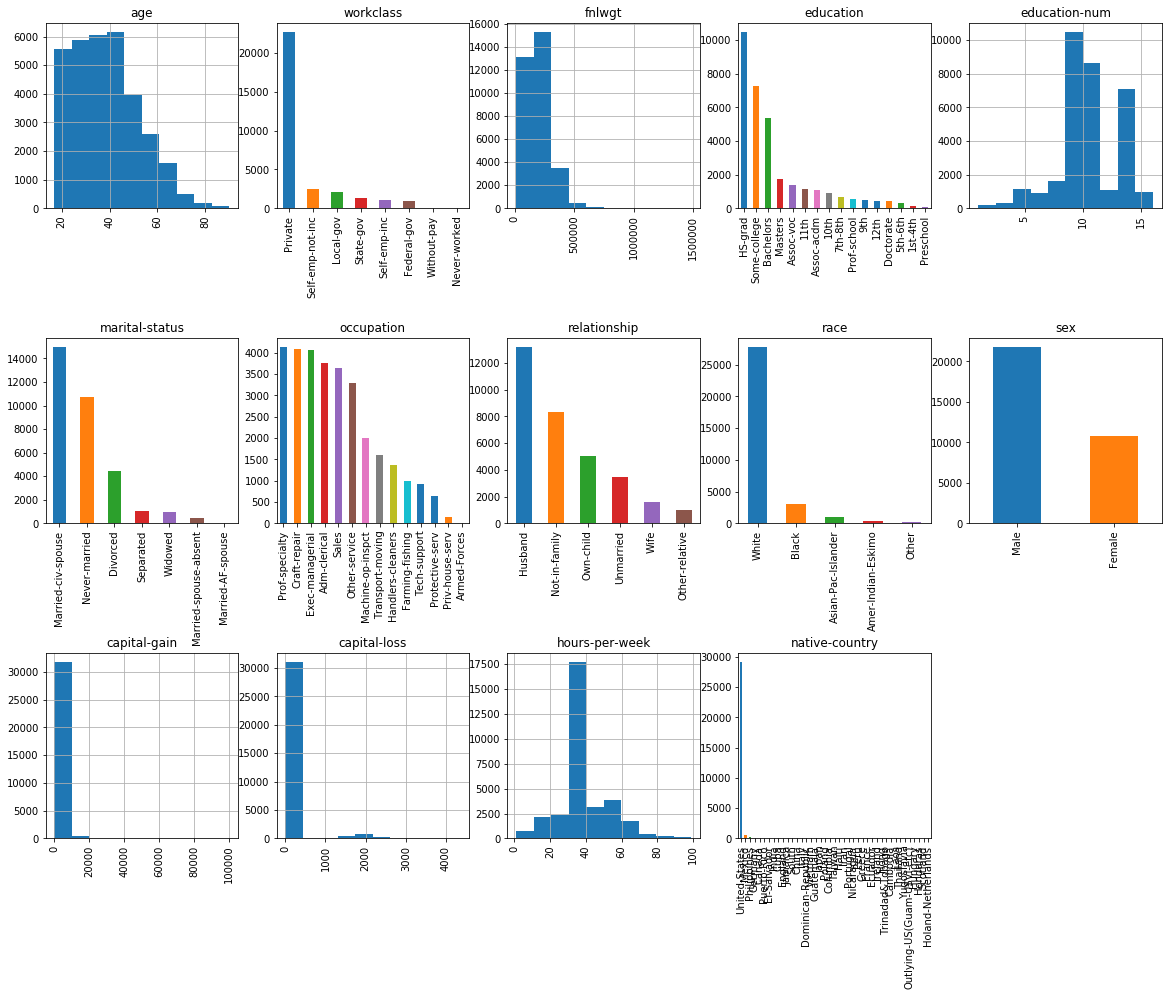

In [11]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(X_train.shape[1]) / cols)
for i, column in enumerate(X_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if X_train.dtypes[column] == np.object:
        X_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        X_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

#### Proportions Relative to the country

In [12]:
(X_train["native-country"].value_counts() / X_train.shape[0]).head()

United-States    0.895857
Mexico           0.019748
Philippines      0.006081
Germany          0.004207
Canada           0.003716
Name: native-country, dtype: float64

#### Missing Data

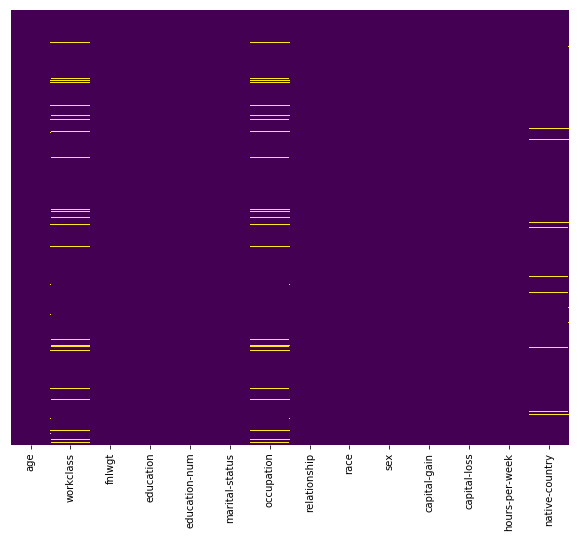

In [13]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### Filling Missing Data 

As we can see, when we analyzed the data we found out the columns working class, occupation and native-country has missing values in them. 

We can also see that majority of working class and native-country are private and United-states respectively. 

We can use this information to fill in the missing values.

In [14]:
X_train['workclass'].fillna(value='Private',inplace=True)

In [15]:
X_train['occupation'].fillna(method='backfill',inplace=True)

In [16]:
X_train['native-country'].fillna(value='United-States',inplace=True)

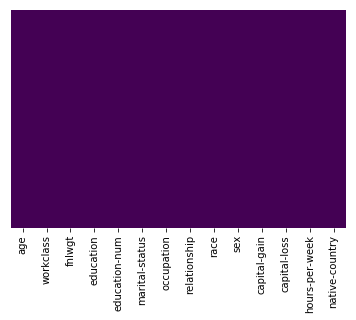

In [17]:
sns.heatmap(X_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### Encode the categorical features as numbers

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


We could use either one hot encodeing or label encoding here. I choose label encoding so that the dimension of the model does not blow out of proportions. This of course is a trade off but with the right model, the peformance should be comparable. For problems such as this where a lot of categorical variables are present, it is a clever choise to use any Tree based algorithm. I will be using a Gradient Boosted Decision Tree Classifier here.  

I wil also demonstrate onehot encoding later here in the same notebook. 

In [19]:
def number_encode_features(df):
    '''
    this function label encodes the categorical variables 
    '''
    
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

#### Calculate the correlation and plot it

just to explore the data a bit more 

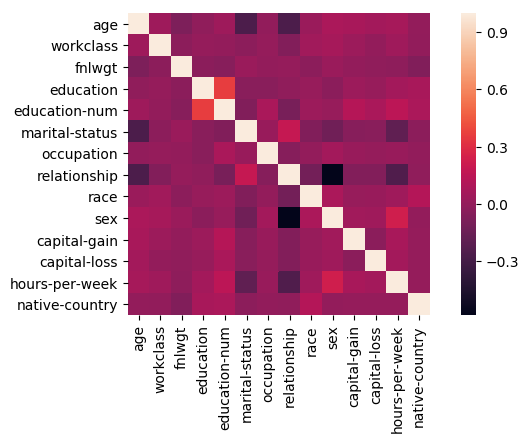

In [20]:
plt.figure(figsize=(8,4),dpi=100)
encoded_data, _ = number_encode_features(X_train)
sns.heatmap(encoded_data.corr(), square=True)

In [21]:
encoded_data.shape

(32561, 14)

 We can see a High correlation between education and education-num. 

In [22]:
X_train[["education", "education-num"]].head(20)

,education,education-num
0,Bachelors,13
1,Bachelors,13
2,HS-grad,9
3,11th,7
4,Bachelors,13
5,Masters,14
6,9th,5
7,HS-grad,9
8,Masters,14
9,Bachelors,13


As we can see these two columns actually represent the same features, but encoded as strings and as numbers. We don’t need the string representation, so we can just delete this column. Note that it is a much better option to delete the Education column as the Education-Num has the important property that the values are ordered: the higher the number, the higher the education that person has. This is a vaulable information a machine learning algorithm can use.

In [23]:
del X_train["education"]

In [24]:
X_train.shape

(32561, 13)

In [25]:
X_train.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


So it seems that the data is mostly OK with the exception of Sex and Relationship, which seems to be negatively correlated. Let’s explore that for a bit

In [26]:
X_train[["sex", "relationship"]].head(20)

,sex,relationship
0,Male,Not-in-family
1,Male,Husband
2,Male,Not-in-family
3,Male,Husband
4,Female,Wife
5,Female,Wife
6,Female,Not-in-family
7,Male,Husband
8,Female,Not-in-family
9,Male,Husband


Yes. The data looks correlated, because for example Male and Husband are highly correlated values, as well as Female and Wife. There is no easy way to tackle this problem, so let’s carry on.

### Building a classifier 

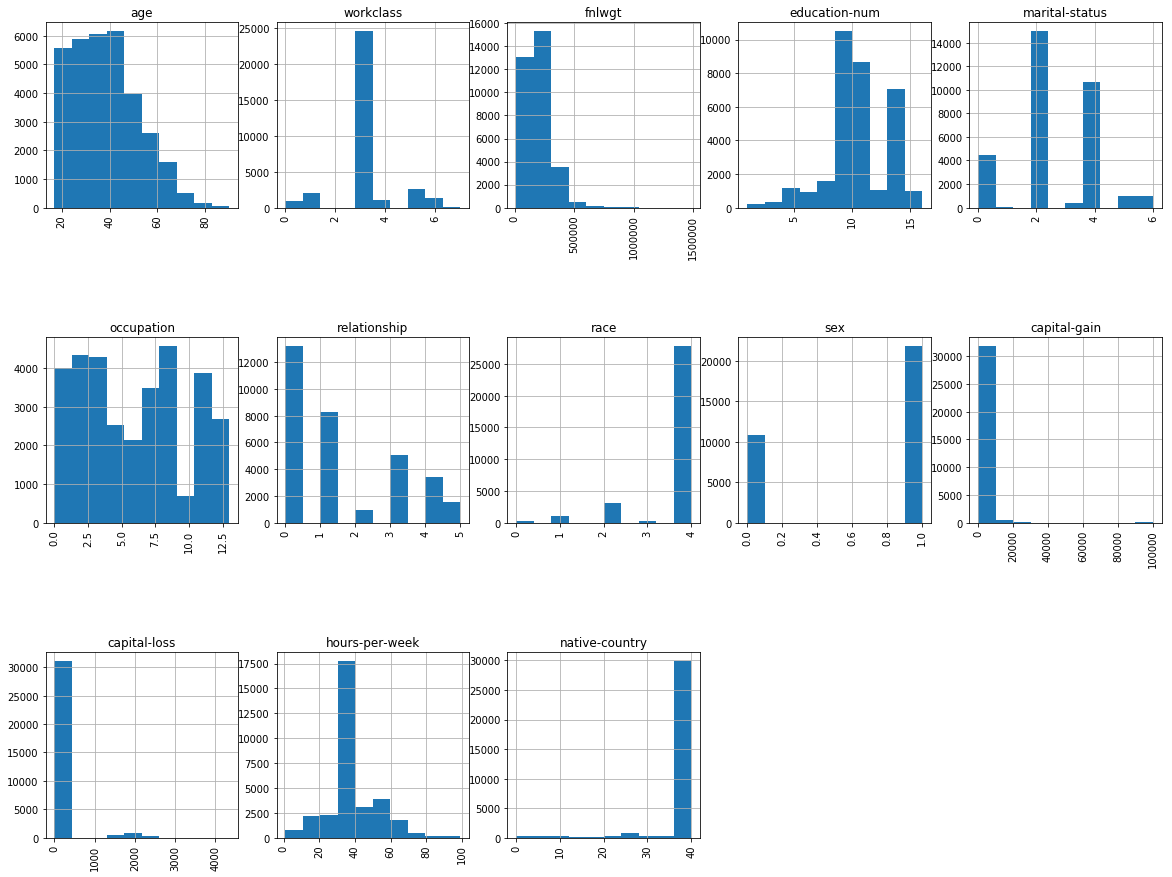

In [27]:
encoded_data, encoders = number_encode_features(X_train)
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

We can that the encoding process has been successfull

#### Split and Scale Data 

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train,_ = number_encode_features(X_train)

In [30]:
 X_train, X_test, y_train, y_test = train_test_split(encoded_data, y_train, test_size=0.3, random_state=101)

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
sc = StandardScaler()

In [33]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Gradient boosting Classifier

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

In [35]:
GB = GradientBoostingClassifier(loss='exponential',learning_rate=0.01,n_estimators=200)

In [36]:
GB.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [37]:
y_pred = GB.predict(X_test)

#### Evaluation

In [38]:
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score,confusion_matrix

In [39]:
print('Accuracy:',accuracy_score(y_test,y_pred))

Accuracy: 0.8537209540382844


In [40]:
print('Classification Report:')
print('\n')
print(classification_report(y_test,y_pred))

Classification Report:


             precision    recall  f1-score   support

          0       0.86      0.97      0.91      7436
          1       0.82      0.50      0.62      2333

avg / total       0.85      0.85      0.84      9769



In [41]:
import itertools

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[7183  253]
 [1176 1157]]


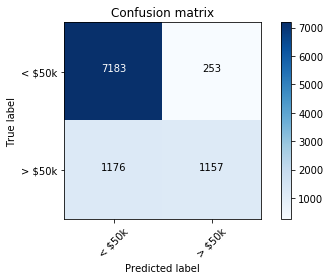

In [43]:
plot_confusion_matrix(cm=confusion_matrix(y_test,y_pred),classes=['< $50k', '> $50k'])

In [44]:
print('roc_auc_score:', roc_auc_score(y_test,y_pred))

roc_auc_score: 0.7309521605368814


### Classification using OneHot Encoding 

Let's see if this imporves the performance. 

In [45]:
X_train_new,y_train_new = get_data()

In [46]:
X_train_new['workclass'].fillna(value='Private',inplace=True)
X_train_new['occupation'].fillna(method='backfill',inplace=True)
X_train_new['native-country'].fillna(value='United-States',inplace=True)

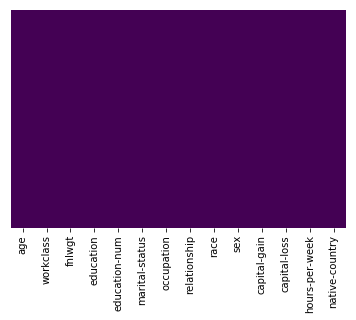

In [47]:
sns.heatmap(X_train_new.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [48]:
X_train_onehot = pd.get_dummies(X_train_new)

In [49]:
X_train_onehot.shape

(32561, 105)

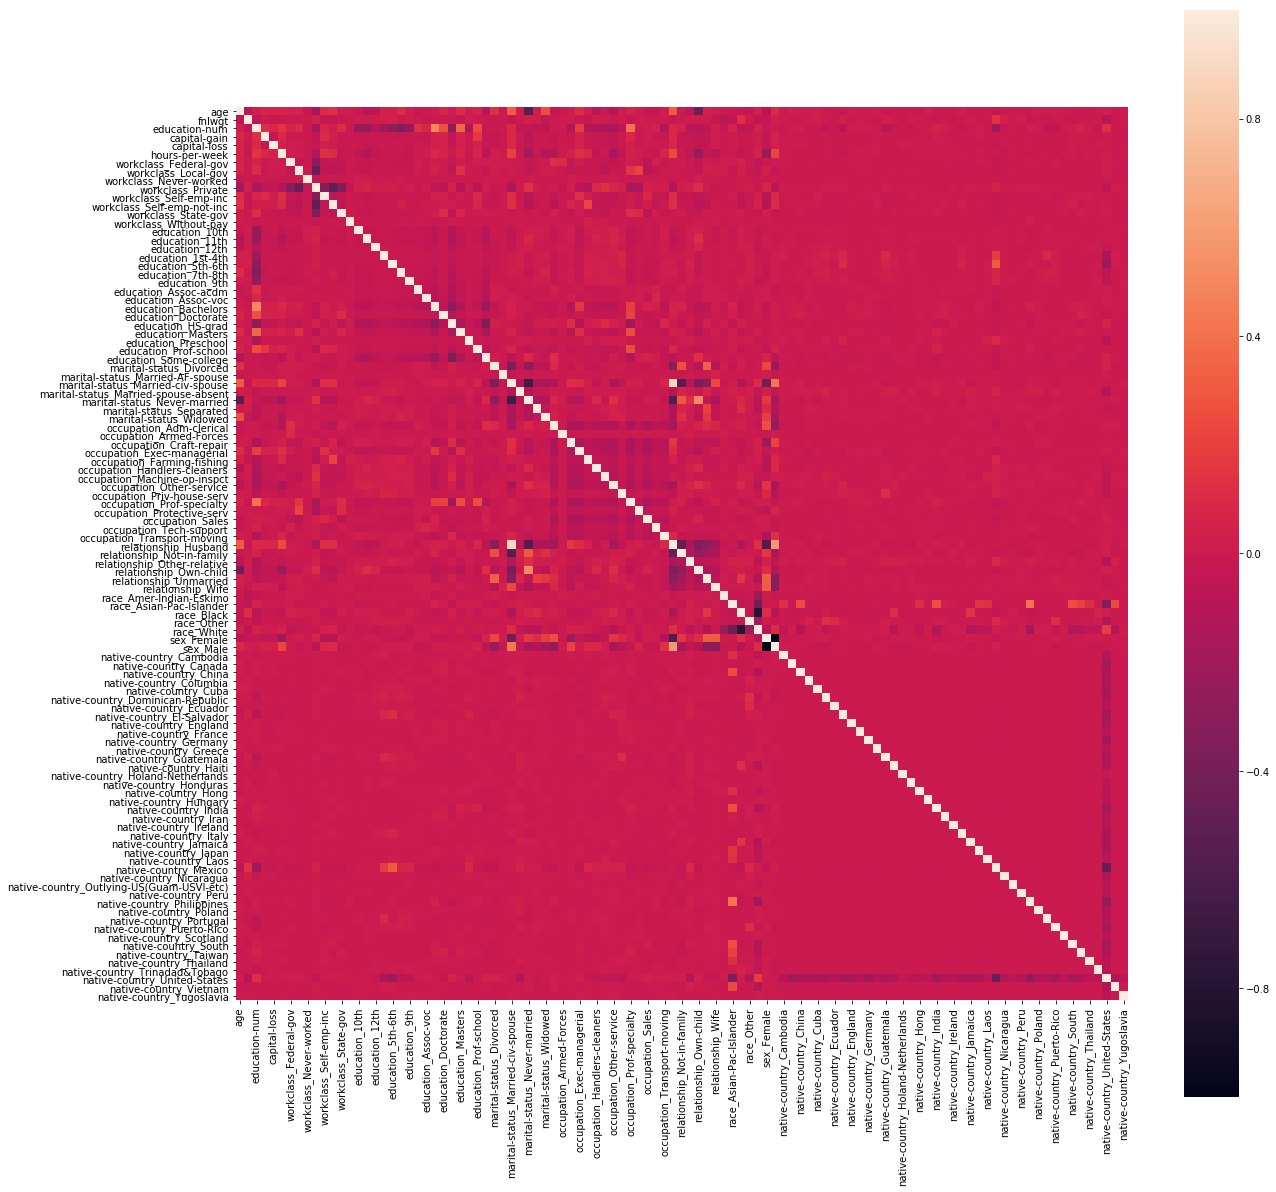

In [50]:
plt.subplots(figsize=(20,20))
sns.heatmap(X_train_onehot.corr(), square=True)

As we can see, we have a lot more features now thanks to onehot encoding!

In [51]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train_onehot, y_train_new, test_size=0.3, random_state=101)

In [52]:
X_train_new = sc.fit_transform(X_train_new)
X_test_new = sc.transform(X_test_new)

In [53]:
GB.fit(X_train_new,y_train_new)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [54]:
y_pred_new = GB.predict(X_test_new)

In [55]:
print('Accuracy:',accuracy_score(y_test_new,y_pred_new))

Accuracy: 0.8554611526256526


In [56]:
print('Classification Report:')
print('\n')
print(classification_report(y_test_new,y_pred_new))

Classification Report:


             precision    recall  f1-score   support

          0       0.86      0.96      0.91      7436
          1       0.82      0.51      0.63      2333

avg / total       0.85      0.86      0.84      9769



In [57]:
print('roc_auc_score:', roc_auc_score(y_test_new,y_pred_new))

roc_auc_score: 0.736507524589888


We can see only a negligible imporvment. As I said before, tree based models are well versed for these kinds of tasks and therefore onehot encoding is unlikely to bring about any serious improvements. We will just be increasing the dimensionality of model, that's all. If it were, say for example a Logistc Regression then onehot encoding will make sense. 